In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
import keras.backend as k
sys.path.append("..")
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.utils import class_weight 
import matplotlib
import matplotlib.pyplot as plt


/home/tofa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/tofa/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
# setup
batch_size = 32
train_dir = "../../images/images_genus/train/"
val_dir = "../../images/images_genus/val/"
train_images = 12525
val_images = 3454
save_model_name = "resnet50_first_L10.h5"
save_plot_name = "resnet50_first_L10_trainplot.png"

In [ ]:
steps_per_epoch = int(train_images/batch_size) + 1
validation_steps = int(val_images/batch_size) + 1

In [2]:
### Model building ####

base_model = ResNet50(
            include_top=False,
            input_shape=(224, 224, 3),
            weights='imagenet')

#add a new dense layer to the end of the network inplace of the old layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# add the outplut layer
predictions = Dense(44, activation='softmax')(x)

# create new model composed of pre-trained network and new final layers
model = Model(input=base_model.input, output=predictions)

for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:10]:
    layer.trainable = False

model.summary()

# compile model
model.compile(loss='categorical_crossentropy',
            optimizer='sgd',
            metrics=['accuracy'])

assert(getLabelsFromDir(train_dir) == getLabelsFromDir(val_dir))
labels = getLabelsFromDir(train_dir)

train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224) )
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224) )



/home/herri/.local/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/herri/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Found 12525 images belonging to 44 classes.
Found 3454 images belonging to 44 classes.


In [3]:
#Train
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps=validation_steps)

Epoch 1/5
392/392 [==============================] - 215s 549ms/step - loss: 0.8923 - acc: 0.7589 - val_loss: 4.0215 - val_acc: 0.0333
Epoch 2/5
392/392 [==============================] - 209s 534ms/step - loss: 0.1507 - acc: 0.9587 - val_loss: 3.8050 - val_acc: 0.0159
Epoch 3/5
392/392 [==============================] - 210s 535ms/step - loss: 0.0511 - acc: 0.9897 - val_loss: 4.0770 - val_acc: 0.0402
Epoch 4/5
392/392 [==============================] - 210s 536ms/step - loss: 0.0272 - acc: 0.9951 - val_loss: 4.3433 - val_acc: 0.0402
Epoch 5/5
392/392 [==============================] - 210s 536ms/step - loss: 0.0128 - acc: 0.9987 - val_loss: 4.2780 - val_acc: 0.0402


In [ ]:
#save
model.save(save_model_name)

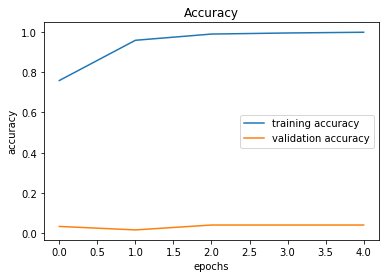

In [4]:
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(save_plot_name, bbox_inches='tight')
plt.show()